# Introdução

O dataset consiste em telemetrias agregadas de dispositivos em galpões do Mercado Livre.
O objetivo é prever falhas no dispositivo para implementar um modelo de manutenção preditiva.
A variável alvo é a coluna failure, que é binária: 0 (sem falha) ou 1 (com falha).

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


In [37]:
data_url = "full_devices.csv" 
df_original = pd.read_csv(data_url, encoding = "ISO-8859-1")

In [38]:
df = df_original.copy()

# Análise exploratória

In [39]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [41]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [42]:
# Verificando a distribuição de valores para colunas numéricas
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    print(f'\nEstatísticas para {col}:\n{df[col].describe()}')


Estatísticas para failure:
count    124494.000000
mean          0.000851
std           0.029167
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: failure, dtype: float64

Estatísticas para attribute1:
count    1.244940e+05
mean     1.223881e+08
std      7.045933e+07
min      0.000000e+00
25%      6.128476e+07
50%      1.227974e+08
75%      1.833096e+08
max      2.441405e+08
Name: attribute1, dtype: float64

Estatísticas para attribute2:
count    124494.000000
mean        159.484762
std        2179.657730
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       64968.000000
Name: attribute2, dtype: float64

Estatísticas para attribute3:
count    124494.000000
mean          9.940455
std         185.747321
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       24929.000000
Name: attribute3, dtype: float64

Estatísticas para att

In [43]:
# Verificando a distribuição de valores para colunas categóricas
for col in df.select_dtypes(include='object').columns:
    print(f'\nContagem de valores únicos para {col}:\n{df[col].value_counts()}')


Contagem de valores únicos para date:
date
2015-01-01    1163
2015-01-02    1163
2015-01-03    1163
2015-01-04    1162
2015-01-05    1161
              ... 
2015-10-27      31
2015-10-29      31
2015-10-30      31
2015-10-31      31
2015-11-02      31
Name: count, Length: 304, dtype: int64

Contagem de valores únicos para device:
device
Z1F0QLC1    304
S1F0KYCR    304
S1F0E9EP    304
S1F0EGMT    304
S1F0FGBQ    304
           ... 
W1F1CHZK      5
W1F1CJKT      5
S1F04KSC      4
W1F0WJFT      3
W1F1DA5ÿ      1
Name: count, Length: 1169, dtype: int64


1. A coluna de falhas (failure) tem uma média muito próxima de 0, o que sugere que a maioria dos dispositivos não falhou.
Isso indica um conjunto de dados desbalanceado.

2. **attribute7** e **attribute8** têm as mesmas estatísticas, o que sugere que elas podem ter valores idênticos ou muito similares. (#TODO explorar a correlação entre eles)

3. As **attribute2**, **attribute3**, **attribute4**, **attribute7**, **attribute8**, e **attribute9**, têm uma mediana(2Q) e terceiro quartil iguais a 0, indicando que há muitos zeros nessas colunas.

4. A coluna **date** indica que temos dados de 304 dias diferentes e a coluna **device** indica que existem 1169 dispositivos únicos no dataset.



# Visualização de dados

## Distribuição de Falhas

detalhamento da distribuição de valores para a coluna alvo 'failure'

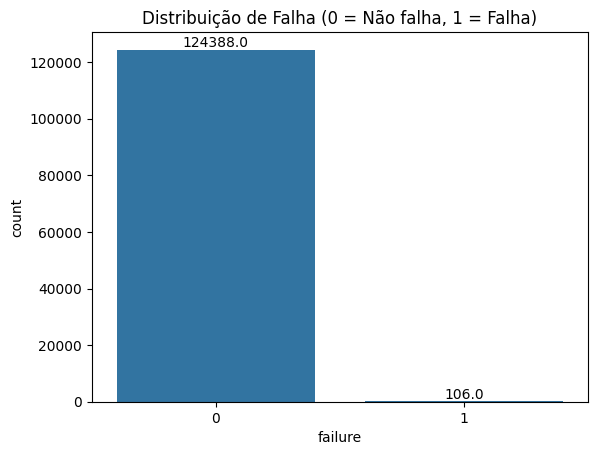

In [44]:
# 1. Distribuição de Falhas
ax = sns.countplot(data=df, x='failure')
plt.title('Distribuição de Falha (0 = Não falha, 1 = Falha)')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.show()


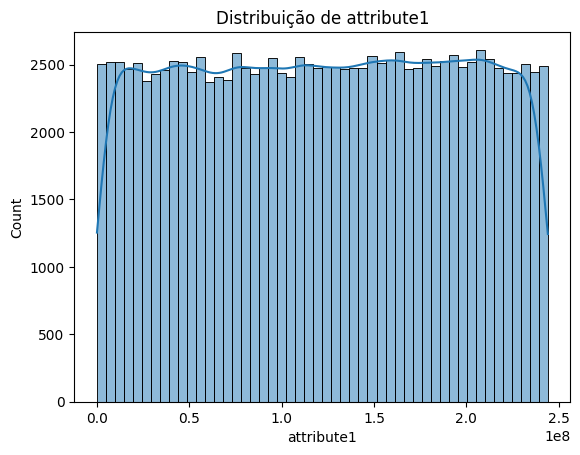

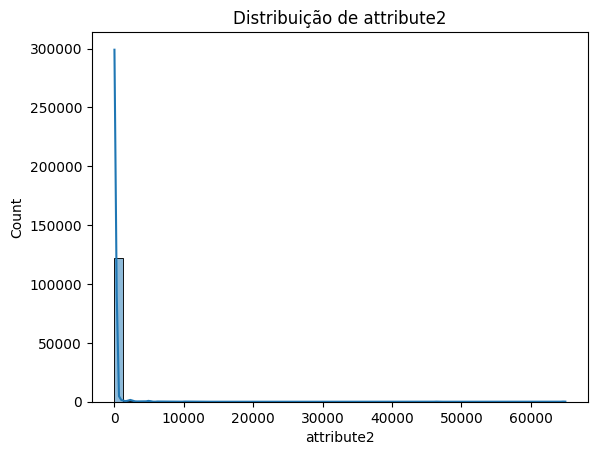

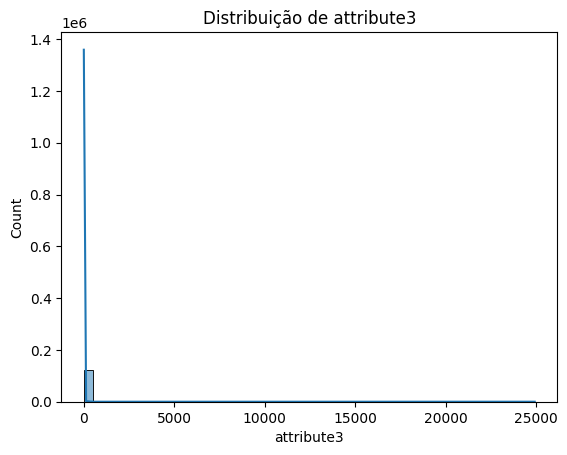

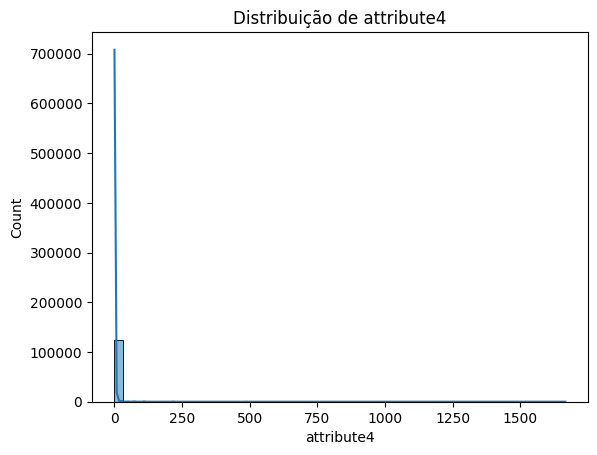

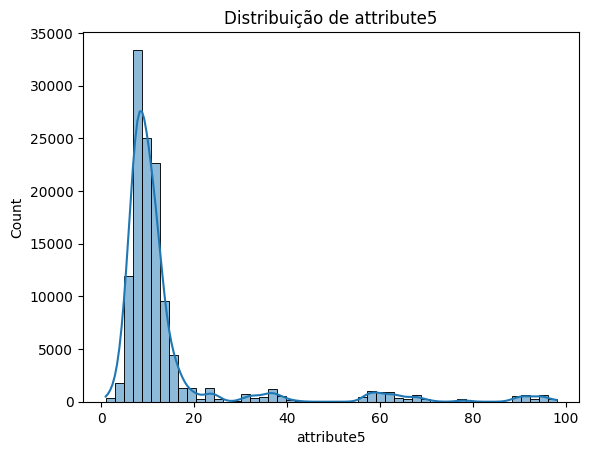

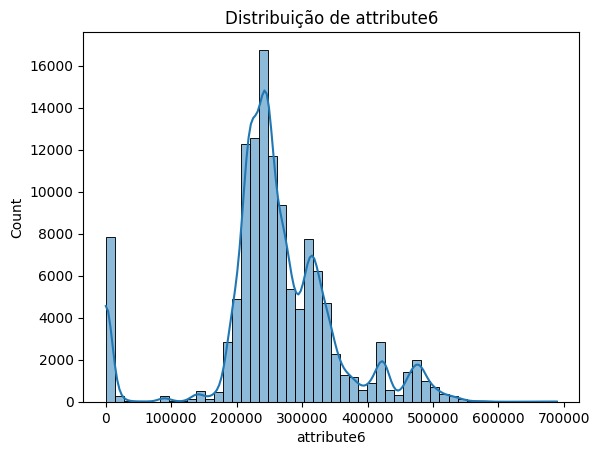

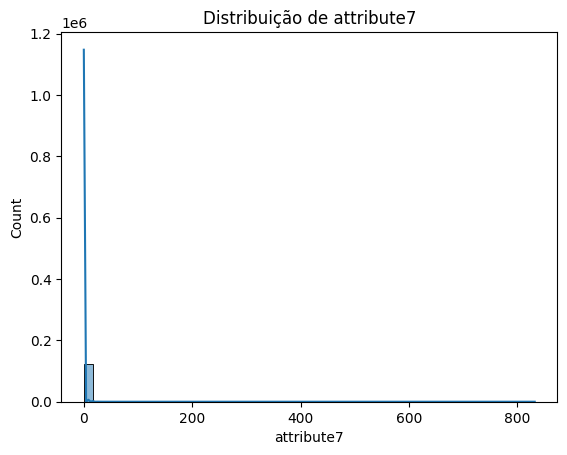

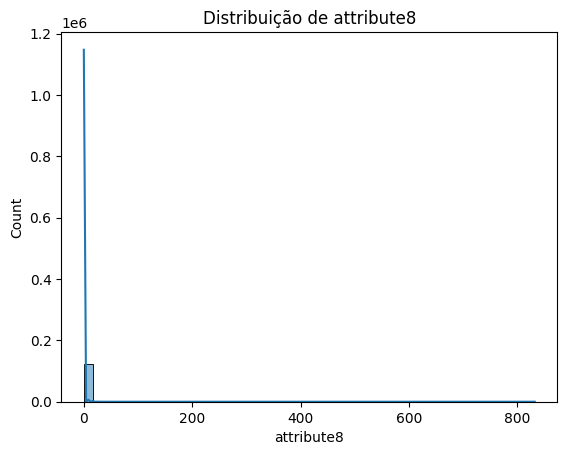

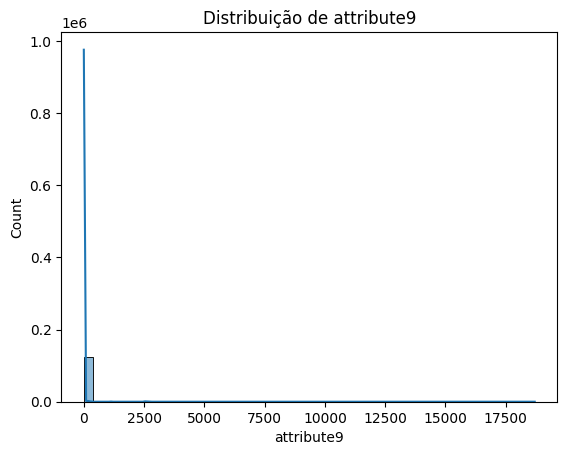

In [45]:
# 2. Histogramas dos Atributos
attributes = df.columns[df.columns.str.contains("attribute")]

for attribute in attributes:
    sns.histplot(df[attribute], bins=50, kde=True)
    plt.title(f'Distribuição de {attribute}')
    plt.show()

1. attribute1 tem em uma distribuição quase uniforme.
2. attribute2, attribute3, attribute4, attribute7, attribute8, e attribute9 a maioria dos valores está concentrada perto de 0, com muitos zeros.
3. attribute5 mostra uma distribuição que parece ter um pico e depois diminui.
4. attribute6 tem uma distribuição que lembra uma forma bimodal, indicando dois grupos principais no conjunto de dados para este atributo.

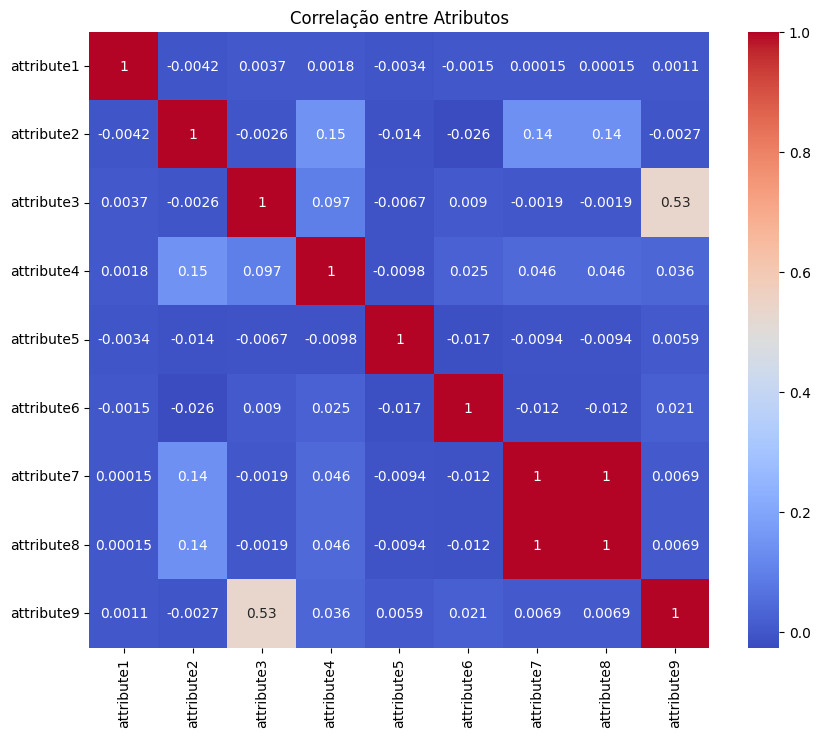

In [46]:
# 3. Correlação
corr_matrix = df[attributes].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlação entre Atributos')
plt.show()

- Há uma correlação perfeita, entre o *attribute7* e *attribute8*, isso não é bom para a modelagem, podendo gerar multicolinearidade.
- A maioria dos atributos não apresenta uma correlação forte entre si. A maior correlação observada é entre *attribute3* e *attribute9*, com um valor de 0.53. Ainda assim, esse valor não é extremamente alto.
- As outras correlações são relativamente baixas, o que indica que os atributos são, em sua maioria, independentes entre si. 

#### Aprofundando nos atrubutos 7 e 8

##### Distribuição dos Valores

<Figure size 1200x600 with 0 Axes>

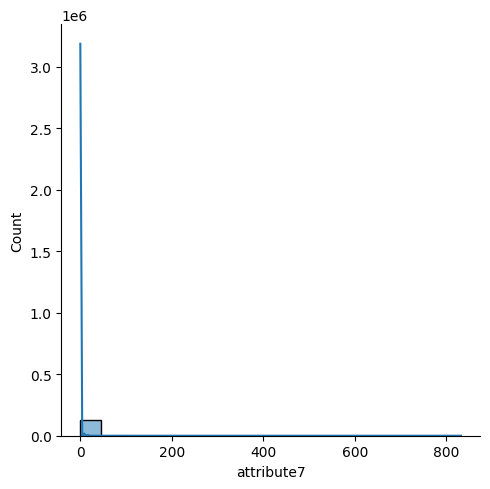

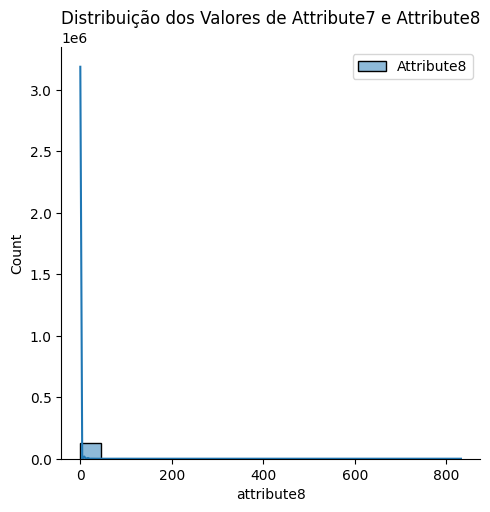

In [47]:
plt.figure(figsize=(12, 6))

sns.displot(df['attribute7'], label='Attribute7', kde=True)
sns.displot(df['attribute8'], label='Attribute8', kde=True)

plt.title('Distribuição dos Valores de Attribute7 e Attribute8')
plt.legend()
plt.show()


##### Comparação direta

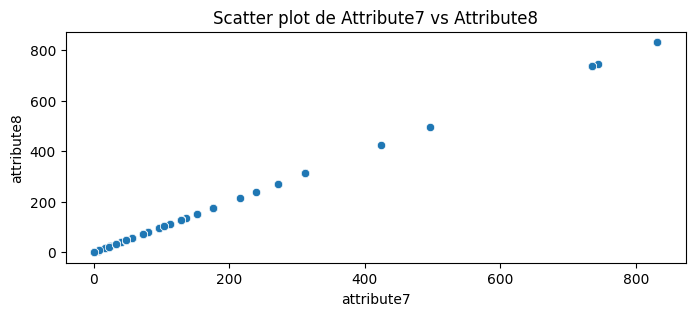

In [48]:
plt.figure(figsize=(8, 3))
sns.scatterplot(x=df['attribute7'], y=df['attribute8'])
plt.title('Scatter plot de Attribute7 vs Attribute8')
plt.show()


A formação da linha perfeita confirma a correlação entre os atributos 7 e 8

##### Valores únicos

In [49]:
print("Valores únicos em Attribute7:", df['attribute7'].nunique())
print("Valores únicos em Attribute8:", df['attribute8'].nunique())


Valores únicos em Attribute7: 28
Valores únicos em Attribute8: 28


**De acordo com TODAS as verificações a respeito das variáveis 7 e 8, faz sentido a remoção por se tratar dos mesmos valores para não haver multicolinearidade e fazendo isso, reduzimos a dimensionalidade dos dados, o que pode acelerar o tempo de treinamento do modelo e diminuindo o risco de overfitting.**

In [50]:
# ***
df = df.drop(columns=['attribute8'])

##  Série Temporal 

Text(0.5, 1.0, 'Falhas ao Longo do Dia')

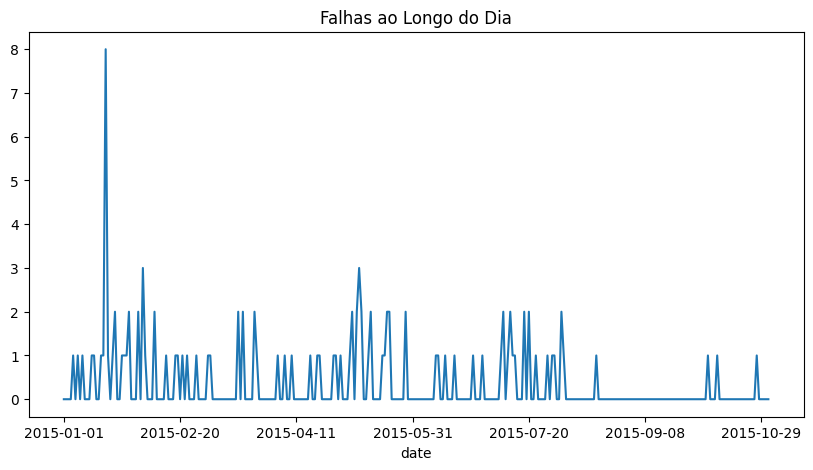

In [51]:
# 4. Série Temporal (assumindo que poucas falhas acontecem por dia)
failures_over_time = df.groupby('date').sum()['failure']
failures_over_time.plot(figsize=(10,5))
plt.title('Falhas ao Longo do Dia')

- Parece q tem irregularidade na ocorrência de falhas ao longo do tempo. Alguns dias apresentam picos mais altos, enquanto outros têm poucas ou nenhuma falha.
- Exploração futura: Esse padrão pode ser explorado mais a fundo em um segundo momento para entendermos se há alguma tendência ou padrão sazonal. (Seria interessante eu entender também se houve algum evento externo que possa explicar os picos de falhas, por exemplo, greve dos correios gerou mais atividades nas máquinas... picos de energia... 

# Tratamento das classes desbalanceadas

Ao invés da utilização da técnica de **Oversampling** ou  **Undersampling**, optei por utilizar a **Geração Sintética de Amostras (SMOTE)**

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

"SMOTE, ou Synthetic Minority Over-sampling Technique, é uma das técnicas mais populares para tratar o desbalanceamento de classes.

Ela funciona selecionando amostras da classe minoritária e gerando novas amostras sintéticas que são combinações dos seus vizinhos mais próximos."

In [52]:
non_numeric_columns = df.select_dtypes(exclude='number').columns
print(non_numeric_columns)

Index(['date', 'device'], dtype='object')


In [53]:
df = df.drop("date", axis=1) #
df = df.drop("device", axis=1)
# Ao invés de remover essas variáveis categóricas, poderíamos codifica-las, mas para efeitos desse desafio, não vou usar essas variáveis.

In [54]:
def prepare_data(df, drop_columns, target_column):
    # Remover colunas especificadas e a coluna alvo
    X = df.drop(drop_columns, axis=1)
    y = df[target_column]
    
    # Aplicar SMOTE para lidar com o desbalanceamento
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Verificando a distribuição das classes após o resampling
    print(pd.Series(y_resampled).value_counts())
    
    return X_resampled, y_resampled


In [55]:
drop_columns = ['failure']  # EColunas para remover do modelo
target_column = 'failure'  # Especifique a coluna alvo
X, y = prepare_data(df, drop_columns, target_column)

df_resampled = pd.DataFrame(data=X, columns=df.drop(drop_columns, axis=1).columns)
df_resampled[target_column] = y


failure
0    124388
1    124388
Name: count, dtype: int64


In [56]:
df_resampled.head()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,failure
0,215630672,56,0,52,6,407438,0,7,0
1,61370680,0,3,0,6,403174,0,0,0
2,173295968,0,0,0,12,237394,0,0,0
3,79694024,0,0,0,6,410186,0,0,0
4,135970480,0,0,0,15,313173,0,3,0


# 2 Treinamento e avaliação de modelos

In [57]:
def train_and_evaluate_model(X, y, test_size=0.3, random_state=42):
    """
    Treina e avalia um modelo RandomForestClassifier.

    Parâmetros:
    - X: Features de treinamento.
    - y: Variável alvo.
    - test_size: Tamanho do conjunto de teste (porcentagem).
    - random_state: Seed para garantir a reprodutibilidade.

    Retorna:
    - Um dicionário com as métricas de avaliação do modelo.
    """
    # Divisão em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Verificando a distribuição das classes após o resampling
    
    # Instanciando o modelo
    clf = RandomForestClassifier(random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Métricas de avaliação
    report = classification_report(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    # Armazenando as métricas em um dicionário
    metrics = {
        "classification_report": report,
        "AUC-ROC": auc_roc,
        "confusion_matrix": confusion,
        "importances": clf.feature_importances_,
        "y_test": y_test 
    }

    return metrics

In [58]:
metrics = train_and_evaluate_model(X, y)

# Exiba as métricas de avaliação
print("Classification Report:")
print(metrics["classification_report"])

print("\nAUC-ROC Score:", metrics["AUC-ROC"])
confusion = metrics["confusion_matrix"]
print("\nConfusion Matrix:")
print(confusion)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37206
           1       1.00      1.00      1.00     37427

    accuracy                           1.00     74633
   macro avg       1.00      1.00      1.00     74633
weighted avg       1.00      1.00      1.00     74633


AUC-ROC Score: 0.9989266503550157

Confusion Matrix:
[[37148    58]
 [   22 37405]]


Acurácia, precisão, recall e F1-score de praticamente 1.00, o q indica que pode haver possível Overfitting.

## Análise da remoção de outliers e novo treinamento do modelo

Comparando os resultados antes e depois da remoção temos:

**Antes da remoção dos outliers:**
- Precisão, recall e f1-score: 1.00 para ambas as classes.
- AUC-ROC Score: 0.99892
- Matriz de Confusão:
  - Verdadeiros Positivos: 37405
  - Verdadeiros Negativos: 37148
  - Falsos Positivos: 58
  - Falsos Negativos: 22

**Após a remoção dos outliers:**
- Precisão, recall e f1-score: 1.00 para ambas as classes.
- AUC-ROC Score: 0.99870 (uma ligeira diminuição)
- Matriz de Confusão:
  - Verdadeiros Positivos: 36050
  - Verdadeiros Negativos: 35773
  - Falsos Positivos: 49 (diminuição em relação ao anterior)
  - Falsos Negativos: 44 (aumento em relação ao anterior)

Comparação:
- A precisão, o recall e o f1-score se mantiveram altos antes e depois da remoçõa dos outliers.
- A AUC-ROC teve uma leve diminuição após a remoção dos outliers.
- Observando a matriz de confusão, houve uma diminuição nos falsos positivos, mas um aumento nos falsos negativos.

Com base nestas observações:

- O modelo já estava performando bem antes da remoção dos outliers, com ótimas métricas.
- A remoção dos outliers não levou a uma melhoria significativa no desempenho do modelo; na verdade, o AUC-ROC diminuiu ligeiramente e o número de falsos negativos aumentou.

Sendo que a remoção dos outliers não trouxe benefícios relevantes em termos de desempenho e pode ser que onere processamento, e como citei anteriormente por se tratar de falhas, pois podem corresponder a eventos raros que são críticos para a detecção falhas representando  anomalias genuínas ou informações valiosas.

**Os outliers dos atributos 2 e 4 não serão removidos!**

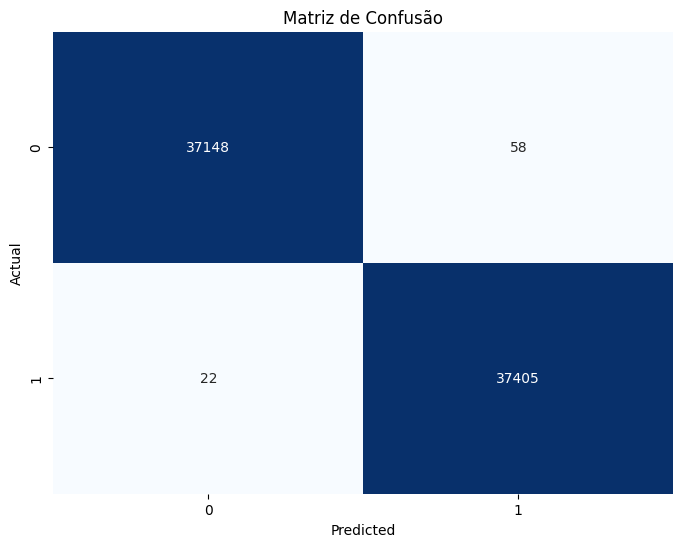

In [59]:
# Matriz de confusão

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
class_names = np.unique(metrics["y_test"])
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names)
plt.yticks(tick_marks + 0.5, class_names)

plt.show()


A Matriz de Confusão é uma ferramenta que permite visualizar o desempenho de um algoritmo de classificação. Vamos interpretar a matriz fornecida:

- **Verdadeiros Positivos (TP):** 37.405 q o modelo previu corretamente nas observações da classe 1 (por exemplo, falhas) e elas realmente são da classe 1.

- **Verdadeiros Negativos (TN):** 37,108 - q o modelo previu corretamente as observações da classe 0 (por exemplo, não-falhas) e elas realmente são da classe 0.

- **Falsos Positivos (FP):**  O modelo previu *incorretamente* que 98 observações são da classe 1 quando, na verdade, são da classe 0.

- **Falsos Negativos (FN):**  O modelo previu *incorretamente* que 25 observações são da classe 0 quando, na verdade, são da classe 1.

Concluo que

1. **Alto Desempenho:** O modelo tem um alto número de verdadeiros positivos e verdadeiros negativos e baixos números de falsos positivos e falsos negativos. Isso indica que estou no caminho certo

2. **Precisão Alta:** Há uma baixa quantidade de falsos positivos em relação aos verdadeiros positivos, indicando uma alta precisão.

3. **Alta Sensibilidade/Recall:** Há uma baixa quantidade de falsos negativos em relação aos verdadeiros positivos, indicando uma alta sensibilidade.

4. **Especificidade:** O número de verdadeiros negativos é significativamente maior do q o de falsos positivos, indicando uma boa especificidade, embora haja uma pequena quantidade de falsos positivos.


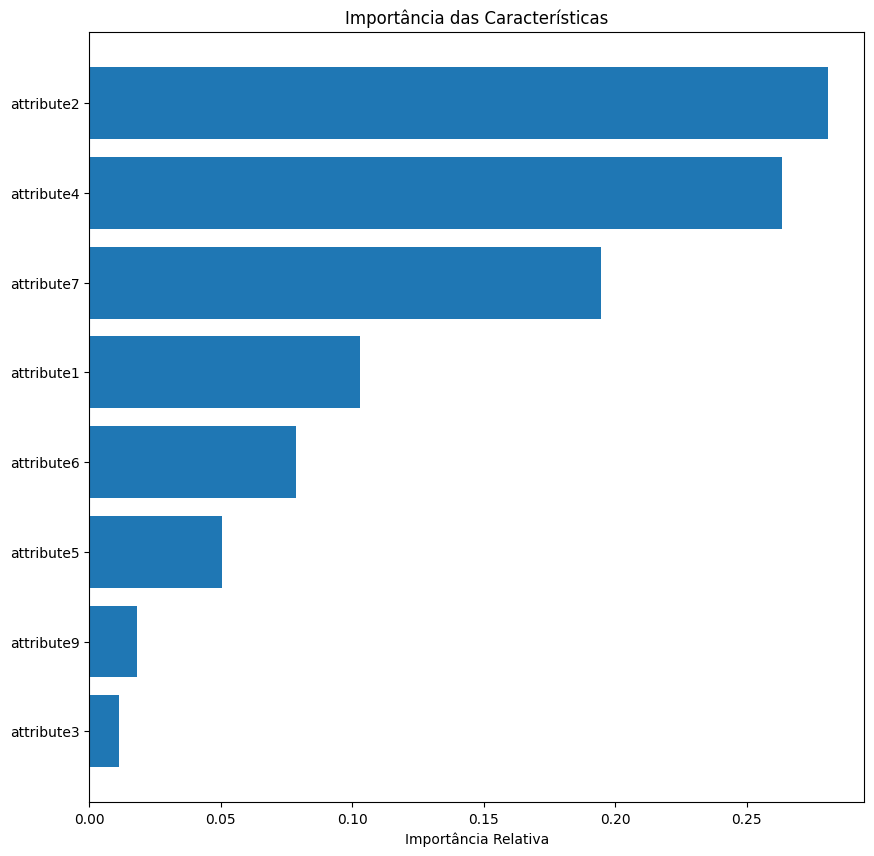

In [60]:
importances = metrics["importances"] #clf.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title('Importância das Características')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importância Relativa')
plt.show()


1. **attribute2** e  **attribute4** parecem ser o recurso mais importante na previsão da falha, com uma importância significativamente maior em relação aos demais atributos. Tem relaão mais forte com a variável alvo.
2. segue em importância, tanto qnto o **attribute2**.
3. Apesar de os atributos **attribute3 e atribute9** não responderem, não vou deletar eles no avanço desse case, é uma próxima exploração.

## Aprodundamento dos atributos relevantes

Dado que o **attribute2** foi identificado como o mais importante na previsão da falha, faz snetido realizar uma análise mais detalhada para entender sua distribuição e relação com a variável alvo.

In [61]:
#Funções de gráfico para facilitar a análise

figsize_l = 12
figsize_h = 6

def plot_histogram(data, column_name, bins=50, kde=True, figsize=(figsize_l, figsize_h)):
    """
    Plota um histograma de uma coluna específica do DataFrame.

    Parâmetros:
    - data: DataFrame contendo os dados.
    - column_name: Nome da coluna a ser plotada.
    - bins: Número de bins para o histograma.
    - kde: Se True, plota também a estimativa de densidade kernel.
    - figsize: Tamanho da figura.

    Retorna:
    - None
    """
    plt.figure(figsize=figsize)
    sns.histplot(data=data, x=column_name, bins=bins, kde=kde)
    plt.title(f'Distribuição de {column_name}')
    plt.show()

def plot_boxplot(data, x_column, y_column=None, figsize=(figsize_l, figsize_h)):
    """
    Plota um boxplot de uma coluna específica ou duas colunas (usando x e y).

    Parâmetros:
    - data: DataFrame contendo os dados.
    - x_column: Nome da coluna usada no eixo x.
    - y_column: Nome da coluna usada no eixo y (opcional).
    - figsize: Tamanho da figura.

    Retorna:
    - None
    """
    plt.figure(figsize=figsize)
    if y_column:
        sns.boxplot(data=data, x=x_column, y=y_column)
        plt.title(f'Boxplot de {x_column} por {y_column}')
    else:
        sns.boxplot(data=data, x=x_column)
        plt.title(f'Boxplot de {x_column}')
    plt.show()

def plot_boxplot_bival(data, x_column, y_column, figsize=(figsize_l, figsize_h), title=None):
    """
    Plota um gráfico de caixa (boxplot) para visualizar a distribuição de uma coluna em relação a outra.

    Parâmetros:
    - data: DataFrame contendo os dados.
    - x_column: Nome da coluna do eixo x.
    - y_column: Nome da coluna do eixo y.
    - figsize: Tamanho da figura.
    - title: Título do gráfico (opcional).

    Retorna:
    - None
    """
    plt.figure(figsize=figsize)
    sns.boxplot(data=data, x=x_column, y=y_column)
    if title:
        plt.title(title)
    else:
        plt.title(f'Boxplot de {y_column} por {x_column}')
    plt.show()

def plot_density(data, x_column, hue_column=None, common_norm=False, figsize=(figsize_l, figsize_h)):
    """
    Plota a estimativa de densidade kernel de uma coluna, opcionalmente colorida por outra coluna.

    Parâmetros:
    - data: DataFrame contendo os dados.
    - x_column: Nome da coluna a ser plotada.
    - hue_column: Nome da coluna usada para colorir a densidade (opcional).
    - common_norm: Se True, normaliza as densidades em todos os níveis de hue.
    - figsize: Tamanho da figura.

    Retorna:
    - None
    """
    plt.figure(figsize=figsize)
    sns.kdeplot(data=data, x=x_column, hue=hue_column, common_norm=common_norm, warn_singular=False)
    plt.title(f'Densidade de Distribuição de {x_column} por {hue_column}' if hue_column else f'Densidade de Distribuição de {x_column}')
    plt.show()


### Análise univariada

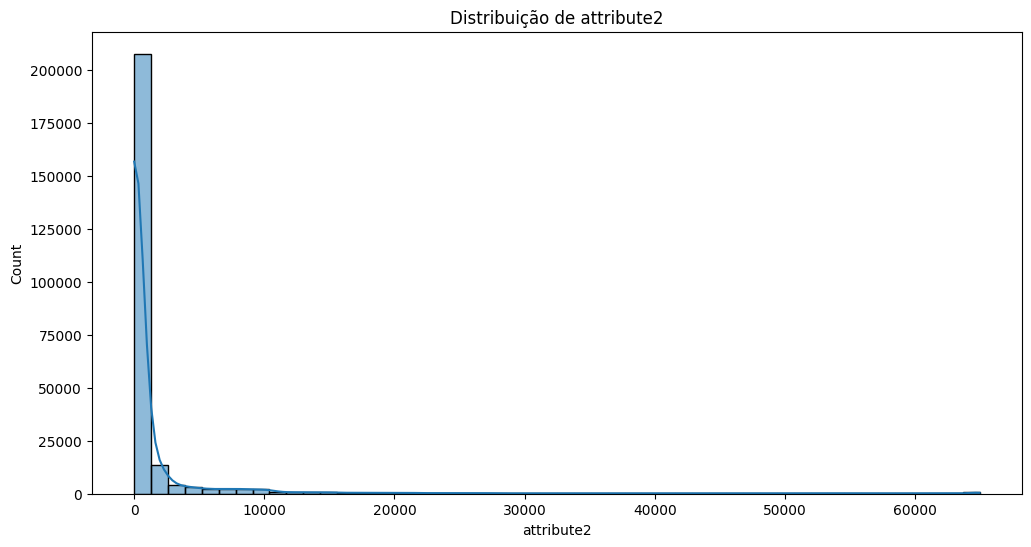

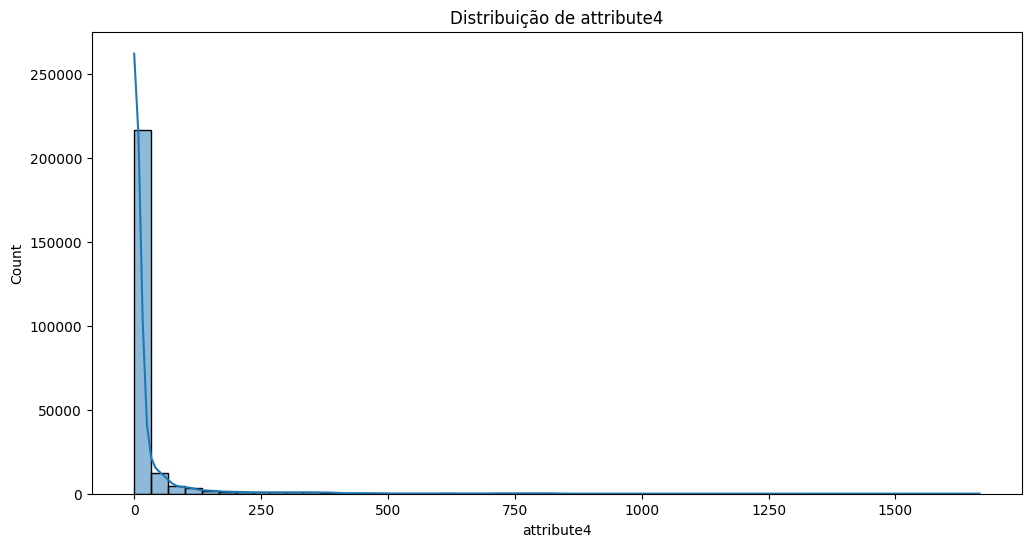

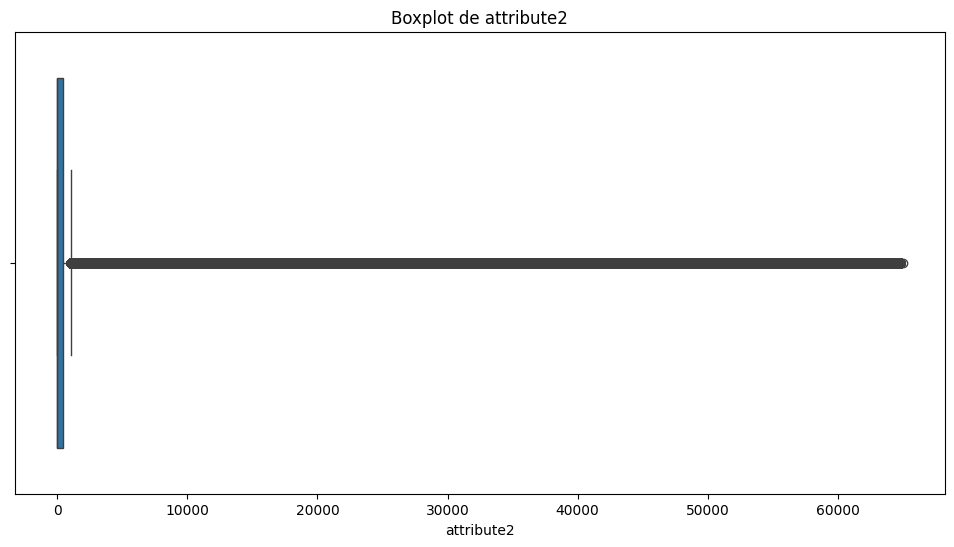

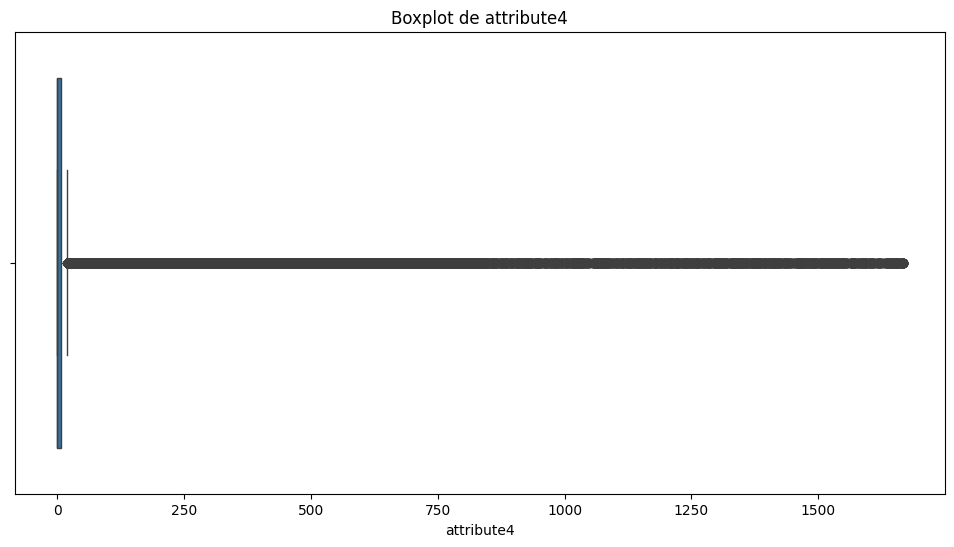

In [62]:
plot_histogram(df_resampled, 'attribute2', bins=50, kde=True)
plot_histogram(df_resampled, 'attribute4', bins=50, kde=True)

# Plot de boxplot
plot_boxplot(df_resampled, 'attribute2')
plot_boxplot(df_resampled, 'attribute4')

- **Histograma**: A distribuição do *attribute2* e *attribute4* é altamente inclinada à esquerda.
Uma grande parte dos dados estão no valor zero ou próx a zero. Indica a presença de outliers, confirmado no gráfico abaixo.
 *attribute2* com alguns outliers se estendendo até 60.000.

- **Boxplot**: confirmado a presença de outliers. Enqto a maioria dos valores estão próximos de zero, há vários pontos que se distanciam indicando valores atípicos.

### Análise bivariada

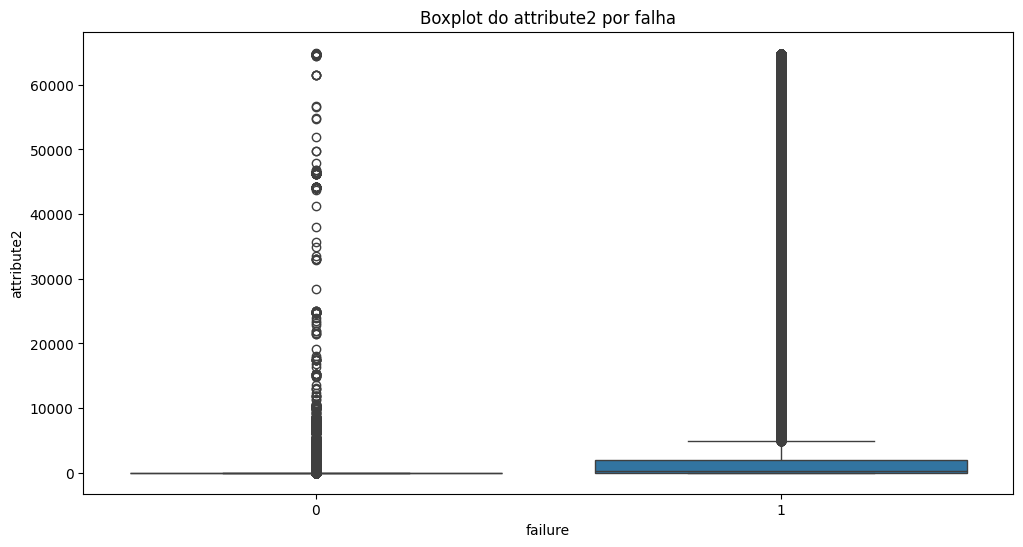

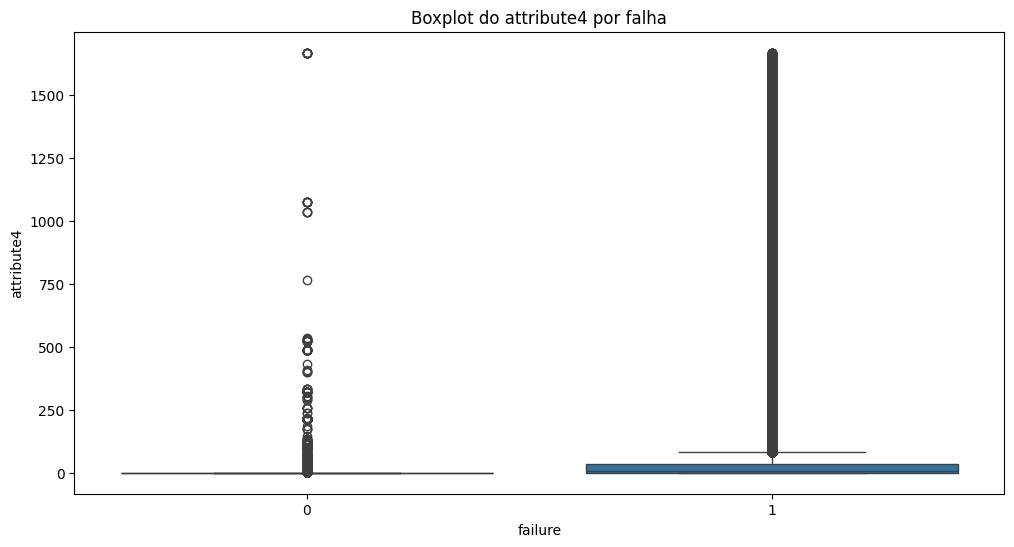

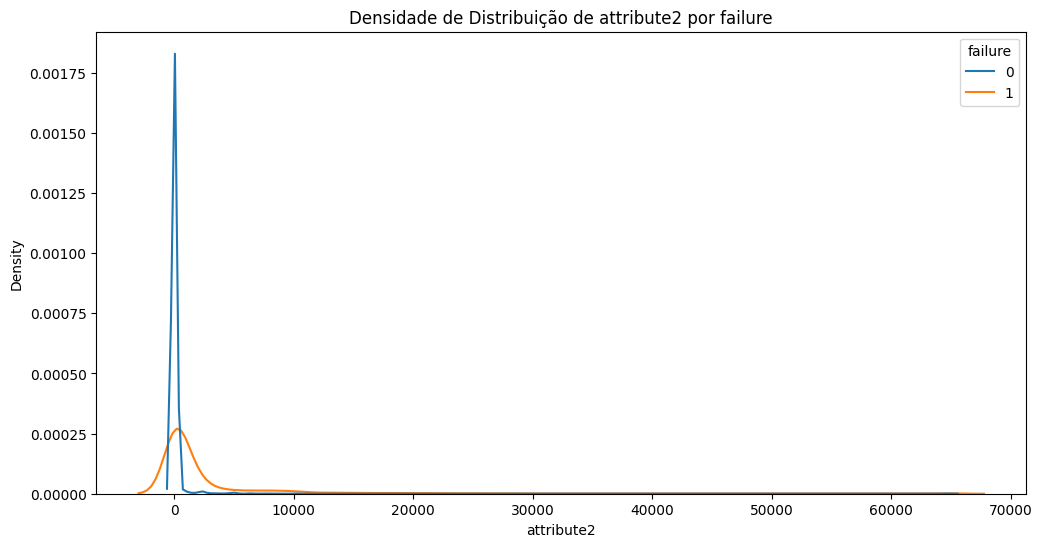

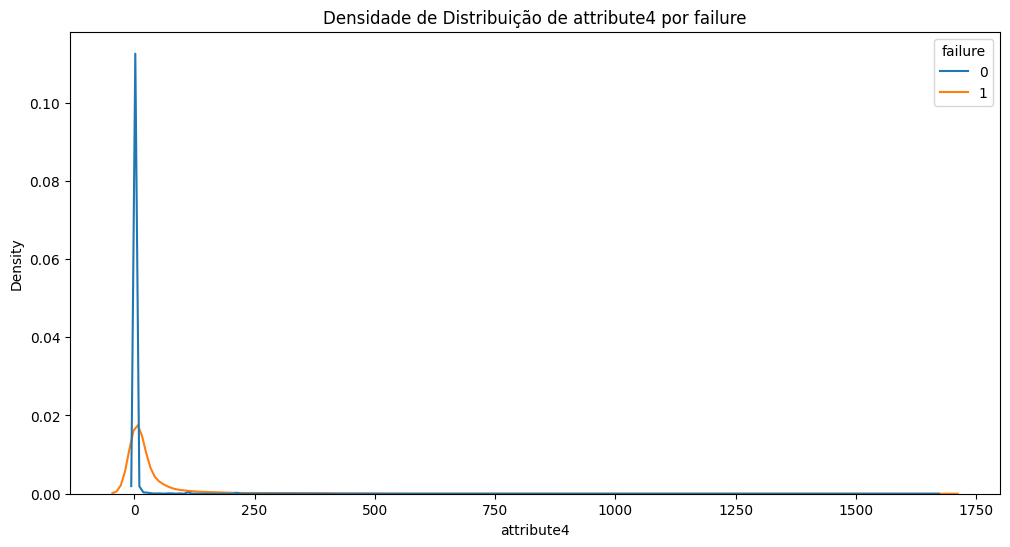

In [63]:
plot_boxplot_bival(df_resampled, x_column='failure', y_column='attribute2', title='Boxplot do attribute2 por falha')
plot_boxplot_bival(df_resampled, x_column='failure', y_column='attribute4', title='Boxplot do attribute4 por falha')

# Plot de densidade
plot_density(df_resampled, 'attribute2', hue_column='failure', common_norm=False)
plot_density(df_resampled, 'attribute4', hue_column='failure', common_norm=False)


**Boxplot**: A distribuição do *attribute4* quando não há falha (failure = 0) mostra uma mediana muito próxima de zero, com alguns outliers.
Entretanto, quando há falha (failure = 1), o valor do attribute4 tende a ser ligeiramente maior. Embora ainda exista uma concentração de valores próximos de zero.

**Gráfico de Densidade:** Há uma concentração clara de valores em ou próximo de zero para ambas as classes (failure = 0 e failure = 1).
A densidade para failure = 1 (falha) se estende um pouco mais do que para failure = 0, o que significa que para valores maiores de attribute4, é mais provável observar uma falha.
O pico pronunciado em zero para failure = 0 (não falha) sugere que a maioria das observações sem falha têm um valor attribute4 de zero.

**O attribute4 e attribute2 e parecem ser um atributo-chave no dataset que pode ser crucial na previsão de falhas.**

# OUTLIERS

Visto que ambos atributos são relevantes para a modelagem e que há outliers, vou fazer a remoção dos mesmos utilizando a abordagem estatística do metodo IQR(Intervalo Interquartil),
que identifica outlires com base na distribuição dos dados.

**Pode ser que haja consequências da remoção nesse contexto de detecção de falhas, pois os outliers aqui podem corresponder a eventos raros que são críticos para a detecção, a remoção deles pode não ser benéfica, mas vale o teste!**

In [64]:
def remove_outliers(df, column_name):
    # Calculando o IQR para a coluna especificada
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definição dos limites para outliers
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Removoção dps outliers na coluna especificada
    df_cleaned  = df[(df[column_name] >= lower_limit) & (df[column_name] <= upper_limit)]
    
    return df_cleaned

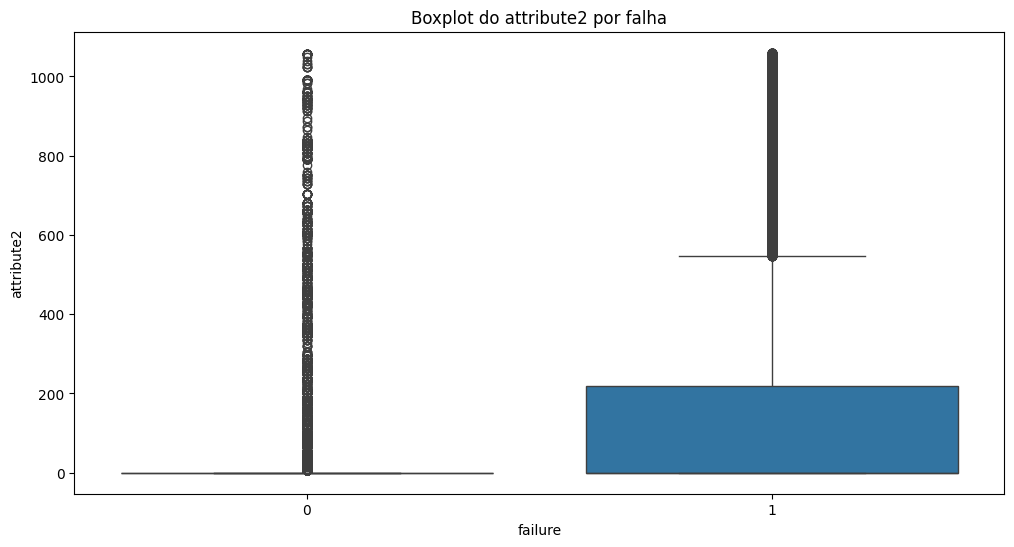

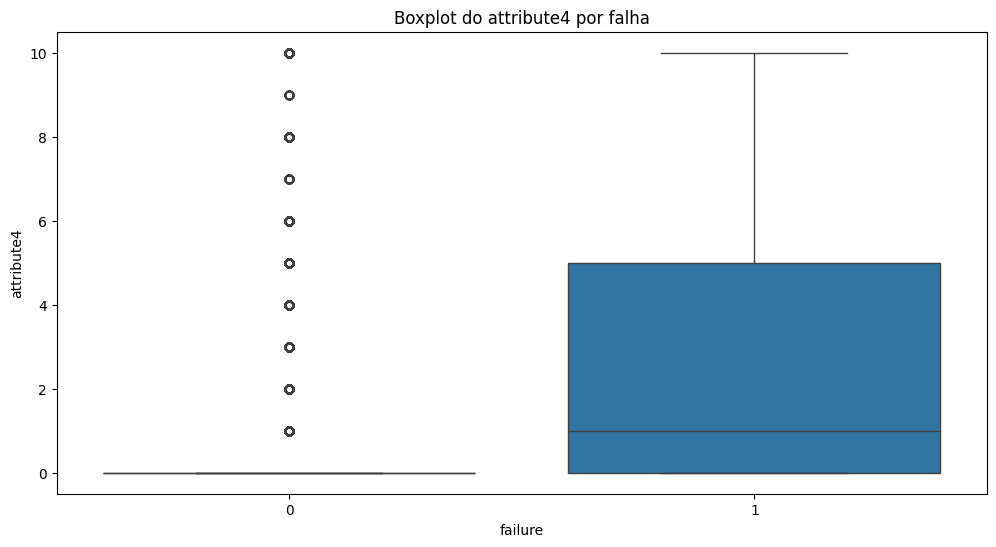

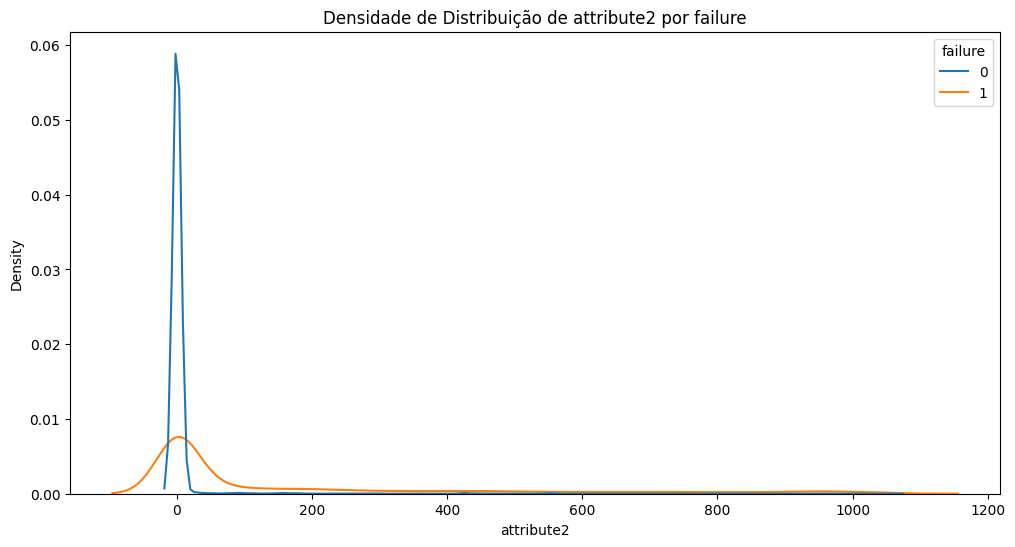

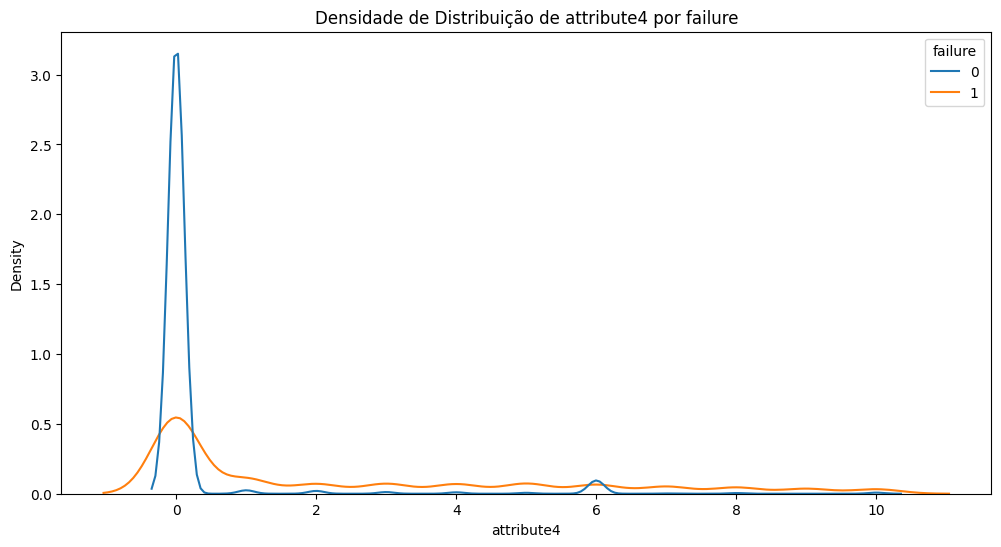

In [65]:
# Remover outliers da coluna 'attribute2'
df_sem_outliers_attribute2_e_4 = remove_outliers(df_resampled, 'attribute2')

# Remover outliers da coluna 'attribute4' no DataFrame resultante da etapa anterior
df_sem_outliers_attribute2_e_4 = remove_outliers(df_sem_outliers_attribute2_e_4, 'attribute4')


plot_boxplot_bival(df_sem_outliers_attribute2_e_4, x_column='failure', y_column='attribute2', title='Boxplot do attribute2 por falha')
plot_boxplot_bival(df_sem_outliers_attribute2_e_4, x_column='failure', y_column='attribute4', title='Boxplot do attribute4 por falha')

# Plot de densidade
plot_density(df_sem_outliers_attribute2_e_4, 'attribute2', hue_column='failure', common_norm=False)
plot_density(df_sem_outliers_attribute2_e_4, 'attribute4', hue_column='failure', common_norm=False)

In [66]:
drop_columns = ['failure']  # EColunas para remover do modelo
target_column = 'failure'  # Especifique a coluna alvo
X, y = prepare_data(df_sem_outliers_attribute2_e_4, drop_columns, target_column)


metrics = train_and_evaluate_model(X, y)

# Exiba as métricas de avaliação
print("Classification Report:")
print(metrics["classification_report"])

print("\nAUC-ROC Score:", metrics["AUC-ROC"])
confusion = metrics["confusion_matrix"]
print("\nConfusion Matrix:")
print(confusion)

failure
0    119859
1    119859
Name: count, dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35822
           1       1.00      1.00      1.00     36094

    accuracy                           1.00     71916
   macro avg       1.00      1.00      1.00     71916
weighted avg       1.00      1.00      1.00     71916


AUC-ROC Score: 0.9987065431669886

Confusion Matrix:
[[35773    49]
 [   44 36050]]


## Análise da remoção de outliers e novo treinamento do modelo

Comparando os resultados antes e depois da remoção temos:

**Antes da remoção dos outliers:**
- Precisão, recall e f1-score: 1.00 para ambas as classes.
- AUC-ROC Score: 0.99892
- Matriz de Confusão:
  - Verdadeiros Positivos: 37405
  - Verdadeiros Negativos: 37148
  - Falsos Positivos: 58
  - Falsos Negativos: 22

**Após a remoção dos outliers:**
- Precisão, recall e f1-score: 1.00 para ambas as classes.
- AUC-ROC Score: 0.99870 (uma ligeira diminuição)
- Matriz de Confusão:
  - Verdadeiros Positivos: 36050
  - Verdadeiros Negativos: 35773
  - Falsos Positivos: 49 (diminuição em relação ao anterior)
  - Falsos Negativos: 44 (aumento em relação ao anterior)

Comparação:
- A precisão, o recall e o f1-score se mantiveram altos antes e depois da remoçõa dos outliers.
- A AUC-ROC teve uma leve diminuição após a remoção dos outliers.
- Observando a matriz de confusão, houve uma diminuição nos falsos positivos, mas um aumento nos falsos negativos.

Com base nestas observações:

- O modelo já estava performando bem antes da remoção dos outliers, com ótimas métricas.
- A remoção dos outliers não levou a uma melhoria significativa no desempenho do modelo; na verdade, o AUC-ROC diminuiu ligeiramente e o número de falsos negativos aumentou.

Sendo que a remoção dos outliers não trouxe benefícios relevantes em termos de desempenho e pode ser que onere processamento, e como citei anteriormente por se tratar de falhas, pois podem corresponder a eventos raros que são críticos para a detecção falhas representando  anomalias genuínas ou informações valiosas.

**Os outliers dos atributos 2 e 4 não serão removidos! Continuarei usando o df_resampled e descartar o df_sem_outliers_attribute2_e_4**

# Cross Validation 

Objetivando testar a generalizaçao do modelo e evitar overfiting faz sentido a validação cruzada 

In [77]:
def cross_validate_model(df, target_column, model):
    
    # Função para realizar a validação cruzada do modelo
    # RandomForestClassifier() 
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    scores = cross_val_score(model, X, y, cv=5)  # Você pode ajustar o número de folds (cv) conforme necessário

    return scores

In [75]:
# model = MLPClassifier()
#model = GradientBoostingClassifier()
#model = LogisticRegression()
#model = SVC()
#model = RandomForestClassifier()
model = RandomForestClassifier()

scores = cross_validate_model(df_resampled, 'failure', model)
# Por motivo do dataset não ser tão grande, não vou paralelilar o processo, mas seria uma possível abordgem

In [78]:
# Exibir métricas de desempenho
print("Média das pontuações da validação cruzada:", np.mean(scores))
print("Desvio padrão das pontuações da validação cruzada:", np.std(scores))
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")


Média das pontuações da validação cruzada: 0.9939503962534838
Desvio padrão das pontuações da validação cruzada: 0.004932581242599885
Accuracy: 0.99 (+/- 0.00)


In [84]:
from sklearn.model_selection import cross_validate

def cross_validate_model(df, target_column, model):
    # Preparação dos dados
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Métricas de avaliação
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    
    # Execução da validação cruzada
    scores = cross_validate(model, X, y, cv=5, scoring=scoring, n_jobs=-1) #Paralelização do processo, sem ele rodou em 5min, com ele rodou em ~2min
    
    # Impressão dos resultados
    for metric in scoring:
        metric_key = f'test_{metric}'
        print(f"{metric.capitalize()} - Média: {scores[metric_key].mean():.4f}, Desvio Padrão: {scores[metric_key].std():.4f}")
    
    return scores


In [85]:
model = RandomForestClassifier(random_state=42)
scores = cross_validate_model(df_resampled, 'failure', model)


Accuracy - Média: 0.9937, Desvio Padrão: 0.0053
Precision - Média: 0.9882, Desvio Padrão: 0.0101
Recall - Média: 0.9994, Desvio Padrão: 0.0005
F1 - Média: 0.9937, Desvio Padrão: 0.0052


## Resultasdos da validação cruzada

Em geral, os resultados mostraram um desempenho muito bom!

- **Accuracy (Acurácia)**: em relação a proporção de predições corretas feitas pelo modelo em relação ao total de predições,  o modelo está acertanto uma média de 99,37% nas predições nos diversos conjuntos de validação (folds).

- **Precision (Precisão)**: A precisão indica a proporção de identificações positivas que estavam realmente corretas, com uma média de 98,82% sugere que quase todas as predições positivas feitas pelo modelo estão corretas.

- **Recall (Sensibilidade)**: O recall indica a proporção de positivos reais que foram identifcados de forma correta. Esta com valor bem alto (99,94%). O modelo é capaz de identificar quase todos os casos positivos nos dados.

- **F1-Score**: Em relação a média harmônica de precisão e recall, que busca equilibrar as duas métricas, o modelo teve uma média de 99,37% é top, e está alinhada com os valores de precisão e recall.

Os desvios padrões mostram que a variabilidade dos resultados entre os diferentes folds é relativamente baixa, sendo assim, o modelo é estável e provavelmente se generalizará bem para novos dados, desde que esses dados sejam semelhantes aos dados de treinamento.

Em resumo, o modelo apresenta um desempenho muito bom nos dados fornecidos, e os resultados da validação cruzada sugerem que ele é robusto e provavelmente terá um bom desempenho em dados não vistos. No entanto, é sempre uma boa prática testar o modelo em um conjunto de dados de teste totalmente independente para verificar sua capacidade de generalização antes de colocá-lo em produção.

In [87]:
#Rodando o cross validation para o DF original, sem tratamentos e com dados desbalanceados
model = RandomForestClassifier(random_state=42)
scores = cross_validate_model(df, 'failure', model) 


Accuracy - Média: 0.9991, Desvio Padrão: 0.0000
Precision - Média: 0.0000, Desvio Padrão: 0.0000
Recall - Média: 0.0000, Desvio Padrão: 0.0000
F1 - Média: 0.0000, Desvio Padrão: 0.0000


**Accuracy (Acurácia) - Média: 0.9991:**  acurácia extremamente alta,  99,91% das predições do modelo estão corretas.

No entanto, olhando para as outras métricas, essa alta acurácia é enganosa.

**Precision, Recall, F1-Score - Média: 0.0000:** Todos esses valores são 0, o que indica que o modelo não está prevendo corretamente qualquer amostra positiva.

Ou Seja, não há nenhuma hipótese em rodar o modelo sem os tratamentos realizados

# Análises futuras:

Como sugestão para análise futura de outras abordagens q eu poderia seguir é
- Organizar o código para a geração de gráficos colocando todos eles em funções corretamente
- Ajustar os hiperparâmetros (tuning) usando alguma ténica como Grid Search para encontrar a melhor combinação dos hiperparâmetros, mas como o medelo já estava ok, obtei por não avançar.
- Em relação aos atributos de maior relevância, seria vi´´avel considerar modelos que podem capturar essa nuance na distribuição dos attribute2 e attribute4. Poderia até criar novas características para as features
- Experimentar outros modvelos como Gradient Boosting Machines, XGBoost ou redes neurais
- Aprofundar nos erros do modelo
- Testar outros tipos de rebalanceamento dos dados como Oversampling e Undersampling ao invés de geração dos dados sintéticos
Enfim, tem muita coisa legal que dá pra explorar aqui ainda.
